In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error

# Load dataset
df = pd.read_csv("data\Retail_Dataset2.csv")

In [91]:
df.head()

,Product_id,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,...,lag_7,rolling_mean_7,rolling_std_7,sma_7,sma_14,ema_7,ema_14,day_of_week,prev_day_demand,rolling_avg_7
6,899733,Product_0643,Whse_A,Category_028,2016-01-03,1.098612,1,0,0,0,...,5.707110,6.309676,3.004656,5.651319,6.292838,5.892681,6.552705,6,10.819798,5.651319
113,996633,Product_1568,Whse_C,Category_019,2016-01-04,6.908755,1,0,0,0,...,3.044522,5.651319,3.603836,6.203352,6.094863,6.146700,6.600178,0,1.098612,6.203352
108,862415,Product_1264,Whse_S,Category_019,2016-01-04,8.517393,1,0,0,0,...,7.601402,6.203352,3.429732,6.334208,6.531970,6.739373,6.855807,0,6.908755,6.334208
109,906104,Product_1431,Whse_C,Category_019,2016-01-04,9.903538,1,0,0,0,...,2.079442,6.334208,3.508531,7.451936,6.909714,7.530414,7.262171,0,8.517393,7.451936
110,864889,Product_0517,Whse_S,Category_022,2016-01-04,2.197225,1,0,0,0,...,6.908755,7.451936,3.155699,6.778860,6.379810,6.197117,6.586845,0,9.903538,6.778860


In [94]:
df.shape

(169198, 28)

In [76]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [77]:
import numpy as np 
df['Order_Demand'] = df['Order_Demand'].clip(lower=0)  # Just in case
df['Order_Demand'] = np.log1p(df['Order_Demand'])  # log(1 + x)

In [78]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)


In [79]:
df['lag_1'] = df['Order_Demand'].shift(1)
df['rolling_mean_3'] = df['Order_Demand'].shift(1).rolling(3).mean()

In [80]:
df['lag_7'] = df['Order_Demand'].shift(7)
df['rolling_mean_7'] = df['Order_Demand'].shift(1).rolling(window=7).mean()
df['rolling_std_7'] = df['Order_Demand'].shift(1).rolling(window=7).std()


In [81]:
df['sma_7'] = df['Order_Demand'].rolling(window=7).mean()
df['sma_14'] = df['Order_Demand'].rolling(window=14).mean()


In [82]:
df['ema_7'] = df['Order_Demand'].ewm(span=7, adjust=False).mean()
df['ema_14'] = df['Order_Demand'].ewm(span=14, adjust=False).mean()


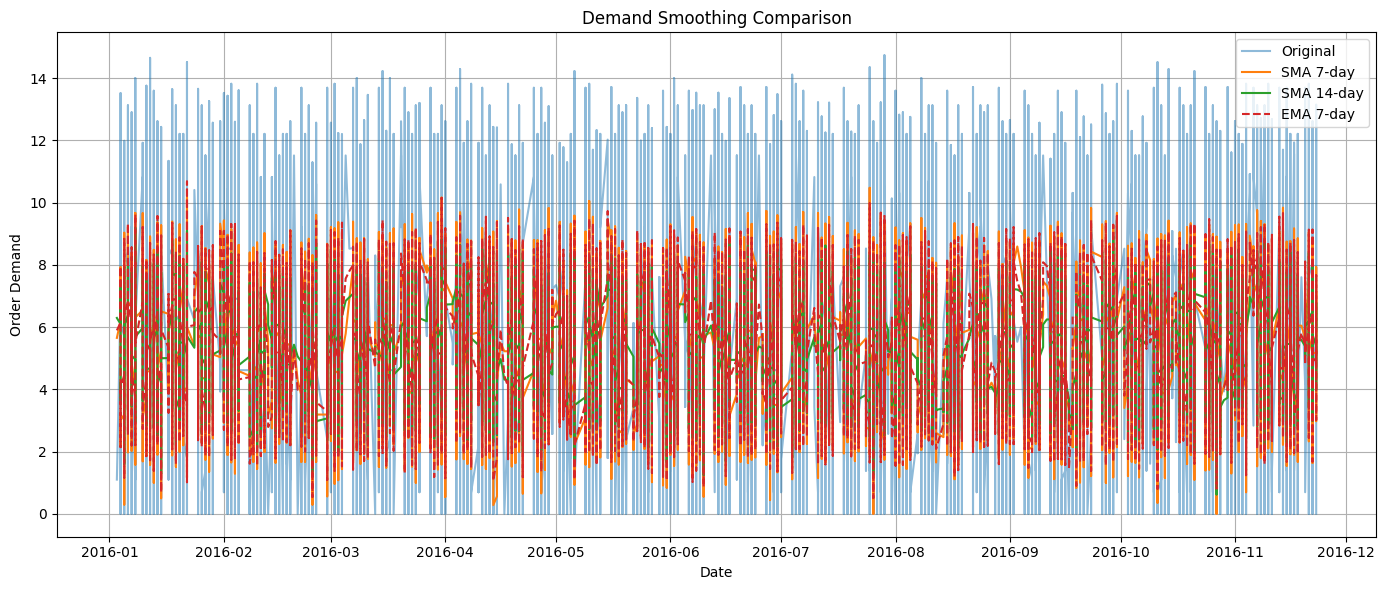

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Order_Demand'], label='Original', alpha=0.5)
plt.plot(df['Date'], df['sma_7'], label='SMA 7-day')
plt.plot(df['Date'], df['sma_14'], label='SMA 14-day')
plt.plot(df['Date'], df['ema_7'], label='EMA 7-day', linestyle='--')
plt.legend()
plt.title('Demand Smoothing Comparison')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


In [88]:
df = df.dropna(subset=['lag_1', 'rolling_mean_3','lag_7','rolling_mean_7','rolling_std_7','sma_14'])

In [90]:
print(df[['lag_1', 'rolling_mean_3','lag_7','rolling_mean_7','rolling_std_7','sma_14']].isnull().sum())

lag_1             0
rolling_mean_3    0
lag_7             0
rolling_mean_7    0
rolling_std_7     0
sma_14            0
dtype: int64


In [96]:
ts = df['Order_Demand']  # replace with your actual column name

# Train-test split (80% train, 20% test)
split_index = int(len(ts) * 0.8)
train = ts.iloc[:split_index]
test = ts.iloc[split_index:]

In [97]:
from pmdarima import auto_arima

stepwise_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=41.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=755540.962, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=719912.880, Time=1.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=11.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=755538.962, Time=0.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=705826.322, Time=3.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=698267.833, Time=3.69 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=693791.868, Time=5.54 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=690500.900, Time=5.50 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=66.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=90.51 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=690498.900, Time=3.96 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=693789.868, Time=3.30 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=31.76 sec
 ARIMA(4,1,1)(0,0,0)[0]            

In [98]:
model = ARIMA(train, order=stepwise_model.order) # (p,d,q) — adjust as needed
model_fit = model.fit()

# Forecast for the test set
forecast = model_fit.forecast(steps=len(test))

In [99]:
r2 = r2_score(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)

print("R² Score:", r2)
print("RMSE:", rmse)

R² Score: -0.05259591667143315
RMSE: 2.986942864949781


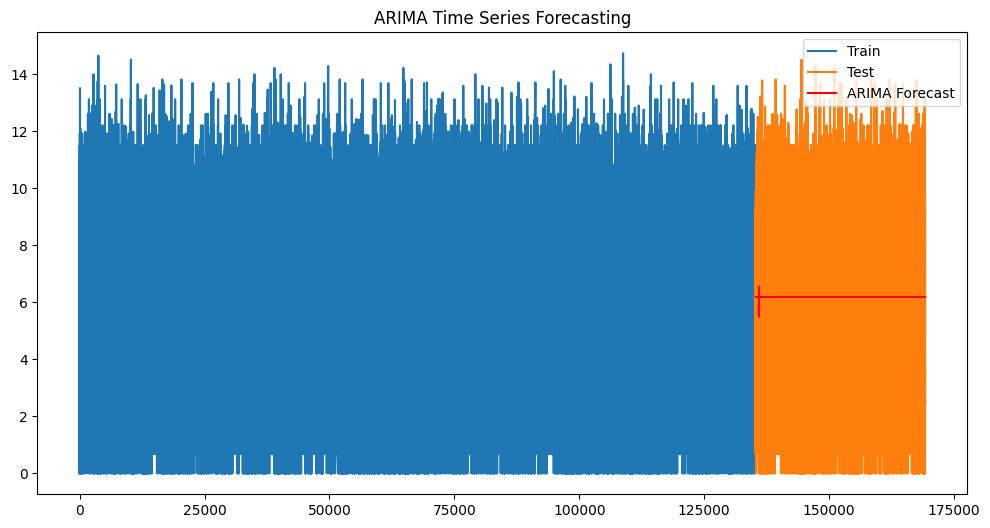

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.title("ARIMA Time Series Forecasting")
plt.legend()
plt.show()
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['prev_day_demand'] = df['Order_Demand'].shift(1)
df['rolling_avg_7'] = df['Order_Demand'].rolling(window=7).mean()


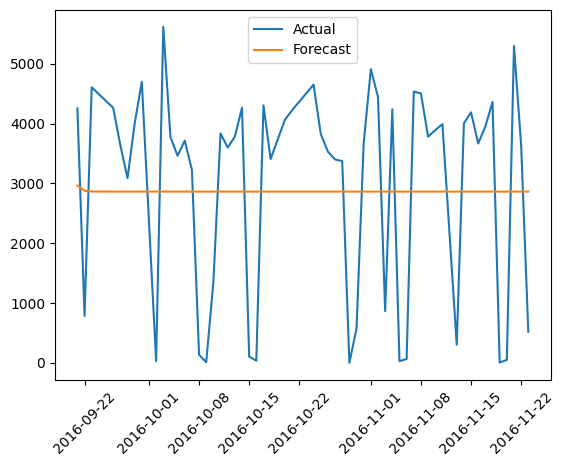

In [101]:
df['Date'] = pd.to_datetime(df['Date'])  # if not already
df['Order_Demand'] = df['Order_Demand'].astype(int)  # clean quantity column

# Group total demand by date
daily_demand = df.groupby('Date')['Order_Demand'].sum().reset_index()

# Now apply ARIMA to total demand
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train_size = int(len(daily_demand) * 0.8)
train, test = daily_demand[:train_size], daily_demand[train_size:]

model = ARIMA(train['Order_Demand'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot actual vs forecast
import matplotlib.pyplot as plt
plt.plot(test['Date'], test['Order_Demand'], label='Actual')
plt.plot(test['Date'], forecast, label='Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [102]:
from pmdarima import auto_arima

# assume `daily_demand` is your time series DataFrame
stepwise_model = auto_arima(train['Order_Demand'], 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

stepwise_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4399.551, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4177.184, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4285.608, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4160.100, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4145.181, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4139.067, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4135.412, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4054.054, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4060.574, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4052.488, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4061.825, Time=0.09 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=4064.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  231
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -1995.959
Date:                Thu, 17 Jul 2025   AIC                           4015.919
Time:                        14:02:28   BIC                           4057.228
Sample:                             0   HQIC                          4032.580
                                - 231                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4394.5873   3770.716      1.165      0.244   -2995.880    1.18e+04
ar.L1          0.4285      0.478      0.896      0.370      -0.508       1.366
ar.L2         -0.8991      0.078    -11.580      0.000      -1.051      -0.747
ar.L3          0.4257      0.450      0.946      0.344      -0.457       1.308
ar.L4         -0.8533      0.064    -13.326      0.000      -0.979      -0.728
ar.L5          0.3799      0.419      0.908      0.364      -0.440       1.200
ma.L1         -0.2861      0.455     -0.629      0.529      -1.177       0.605
ma.L2          0.7589      0.115      6.600      0.000       0.534       0.984
ma.L3         -0.3111      0.406     -0.766      0.444      -1.107       0.485
ma.L4          0.5783      0.110      5.237      0.000       0.362       0.795
ma.L5         -0.4294      0.300     -1.433      0.152      -1.017       0.158
sigma2      1.941e+06   2.39e+05      8.122      0.000    1.47e+06    2.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.51   Prob(JB):                         0.35
Heteroskedasticity (H):               1.21   Skew:                            -0.12
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
forecast = stepwise_model.predict(n_periods=len(test))


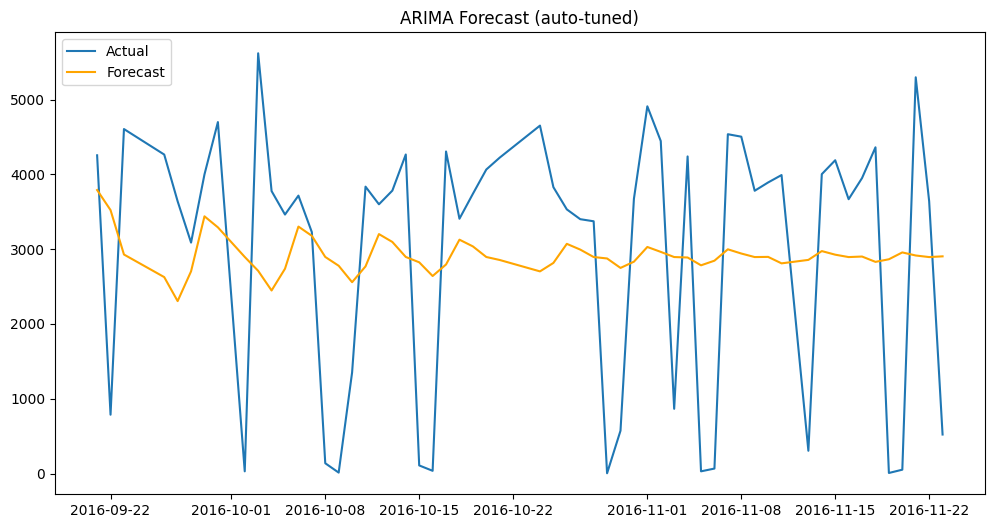

In [104]:
plt.figure(figsize=(12,6))
plt.plot(test['Date'], test['Order_Demand'], label='Actual')
plt.plot(test['Date'], forecast, label='Forecast', color='orange')
plt.title('ARIMA Forecast (auto-tuned)')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4055.719, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4070.426, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4070.430, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4069.100, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4399.551, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4074.272, Time=0.12 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=4074.363, Time=0.28 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=4053.824, Time=0.50 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=4075.333, Time=0.50 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=4055.012, Time=0.83 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=4054.083, Time=0.46 sec
 ARIMA(1,0,2)(2,0,1)[7] intercept   : AIC=4072.666, Time=0.35 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=4074.491, Time=0.31 sec
 ARIMA(3,0,2)(2,0,1)[7] intercept   : AIC=4056.503, Time=0.64 sec
 ARIMA(2,0,3)(2,0,1)[7] intercept

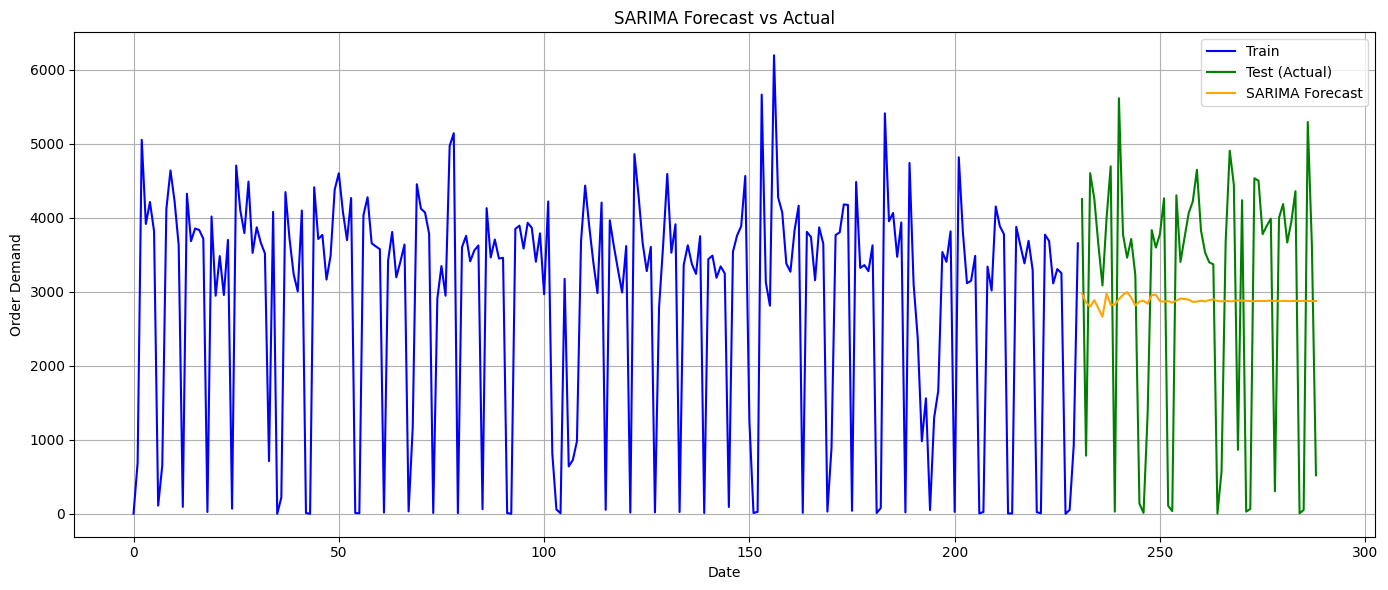

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Train SARIMA
sarima_model = auto_arima(train['Order_Demand'],
                          seasonal=True,
                          m=7,  # Weekly seasonality
                          trace=True,
                          stepwise=True,
                          suppress_warnings=True)

# Forecast on test set
sarima_forecast = sarima_model.predict(n_periods=len(test))

# Plot actual vs forecast
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Order_Demand'], label='Train', color='blue')
plt.plot(test.index, test['Order_Demand'], label='Test (Actual)', color='green')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Order Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
